# ✪ Avengers Recognition with Keras Transfer Learning ✪

**Machine Learning Image Multiclass Classification**

---


Hi Superhero,

This notebook builds an end-to-end multiclass image classifier using Keras (from TensorFlow) and transfer learning method. With this you will be able to recognize the Avengers superhero without knowing the whole universe.

The plan for this project is as follows:

1. Prepare our workspace
1. Check data
1. Create data loader and setup data transforms
1. Create the model using a pretrained model (ResNet50)
1. Train and evaluate the model
1. Save and load the model
1. Check the model on sample images


Alright, let's get started!

## 1. Prepare our workspace

Firstly, we need necessary packages with core libraries.

In [1]:
# !pip install matplotlib
# !pip install torchvision
# !pip install numpy
# !pip install tensorflow

Now we import libraries which we are going to use in this project. 

In [2]:
import os, random, time, copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Lower the reporting level of TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.config import list_physical_devices
from tensorflow.image import resize

# Keras
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Sequential, Model, Input, layers, optimizers, losses, callbacks
from tensorflow.keras.models import load_model

In the above, we lower the warning level at some point. We do it because in our case I don't use the GPU which is recommended for TensorFlow.

In [3]:
# Check for GPU availability
print("GPU", "available" if list_physical_devices("GPU") else "not available")

GPU not available


I have to use a good old CPU (Intel i7-4770k). However, for our purpose it turns out to be sufficient.

At the end, we check and display versions of our packages.

In [4]:
import sys
import matplotlib

print(f'Python: {sys.version}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'NumPy: {np.__version__}')
print(f'TensorFlow: {tf.__version__}')
print(f'Keras: {tf.keras.__version__}')

Python: 3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
Matplotlib: 3.6.2
NumPy: 1.23.3
TensorFlow: 2.10.1
Keras: 2.10.0


## 2. Check data

Let's look at the structure of our `data` folder.

In [5]:
# Data folder path
data_path = "data"

def list_files(path):
    """
    Display the directory structure with information 
    about the number of supported image formats:
    """
    # Image formats supported by Keras
    supported_img_format = ['.png', '.jpg', '.jpeg', '.bmp',
                            '.ppm', '.tif', '.tiff']
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        # Print current directory with a level indent 
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        if files:            
            num_images = sum(1 for file in files 
                                   if '.' + file.split('.')[-1].lower() 
                                   in supported_img_format)
            # Print number of supported images if any
            print(f'{subindent}<<{num_images} image files>>')

list_files('data')

data/
    validation/
        captain-america/
            <<50 image files>>
        iron-man/
            <<50 image files>>
        thor/
            <<50 image files>>
        hulk/
            <<50 image files>>
    test-sample/
        <<12 image files>>
    train/
        captain-america/
            <<350 image files>>
        iron-man/
            <<350 image files>>
        thor/
            <<350 image files>>
        hulk/
            <<350 image files>>


As we can see, we have 350 test images and 50 validation images for each class.

Let's show some random image examples.

In [6]:
train_data_path = os.path.join(data_path, 'train')
validation_data_path = os.path.join(data_path, 'validation')

# Paths to individual directories 
avengers_paths = [os.path.join(train_data_path, dir) 
                  for dir in os.listdir(train_data_path)]

# Remove paths to files or empty directories
for item in list(avengers_paths):  
    if not os.path.isdir(item) or len(os.listdir(item)) == 0:
        avengers_paths.remove(item)

# List Avengers labels
avengers_labels = [path.split('/')[-1] for path in avengers_paths]

# List random Avengers images
random_avengers = [Image.open(os.path.join(path, random.choice(os.listdir(path)))) 
                   for path in avengers_paths]

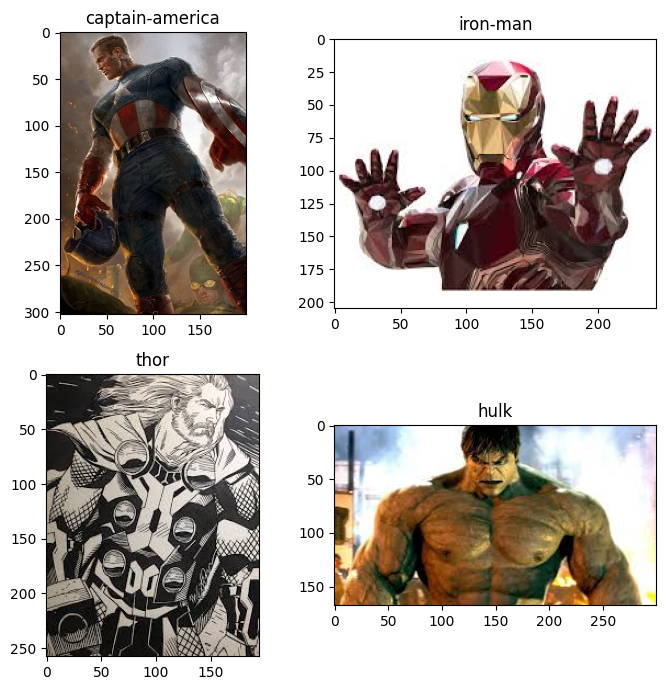

In [7]:
# Draw a representation of the Avengers (4 at the moment)
plt.figure(figsize=(7, 7))

for i in range(4):
    # Create subplots (2 rows, 2 columns)
    ax = plt.subplot(2, 2, i+1)
    # Display an image
    plt.imshow(random_avengers[i])
    # Add the image label as the title
    plt.title(avengers_labels[i])

# Set tight layout
plt.tight_layout(h_pad=1)

In addition, it's worth to emphasize that the data has been previously checked for the possibility of duplication or very similar pictures. This [Duplicate Image Finder (difPy)](https://github.com/elisemercury/Duplicate-Image-Finder) was used for this purpose.

Ok, as everything seems fine, let's move on.

## 3. Create data loader and setup data transforms

We set our data loaders using `image_dataset_from_directory()` method which expects our data to be organized in the following way: `root/label/image.jpg` with separate folders for training and validation data - just like we have.

You can read more about it [in the documentation](https://www.tensorflow.org/tutorials/load_data/images).

In [8]:
batch_size = 32
image_size = (224,224)

image_datasets = {
    'train': image_dataset_from_directory(
        directory=train_data_path,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True),

    'validation': image_dataset_from_directory(
        directory=validation_data_path,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=False)
}
print()

Found 1400 files belonging to 4 classes.
Found 200 files belonging to 4 classes.



Now we set our data transforms. 

First, we set up a data augmentation transformer which is supposed to:

* apply random horizontal filp ([about it](https://paperswithcode.com/method/randomhorizontalflip)),
* apply random rotation ([about it](https://www.studytonight.com/post/image-rotation-augmentation-keras-imagedatagenerator)),
* apply random zoom ([about it](https://www.studytonight.com/post/random-zoom-image-augmentation-keras-imagedatagenerator)).

Of course, we only apply this on training data. 

By the way, I recommend [this article](https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/), where various examples of data agumentation in Keras have been described and shown.

In [9]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In addition, we need to prepare our data for the network that we intend to use in the next step.

In our case, it'll be the ResNet-50 convolutional neural network (more info later). Keras has an `resnet50.preprocess_input` method implemented for this network that we're going to use. 

There are two ways to implement data augmentation and the `preprocess_input` mentioned above:
* use them as a layer of the constructed network,
* apply them to the data before entering it into the neural network.

As recommended in the [documentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#preprocessing_data_before_the_model_or_inside_the_model), taking into account the use of the CPU (instead of the GPU), we use the above transformers now, before we'll push the data into the model.

In [10]:
# Disable some tf warnings (due to no GPU)
tf.get_logger().setLevel('ERROR')

# Apply data augmentation on training data as mapping
image_datasets['train'] = image_datasets['train'].map(
    lambda x, y: (data_augmentation(x), y))

x = tf.cast(i, tf.float32)


# Apply model preprocessing on both datasets
AUTOTUNE = tf.data.AUTOTUNE
for subset in ['train', 'validation']:
    image_datasets[subset] = image_datasets[subset].map(
        lambda x, y: (preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE)

Ok, we can move on to the most exciting part. 🙂

## 4. Create the model using a pretrained model (ResNet50)

We want to import a pre-trained model, freeze all its convolutional layers, and train only the last one(s).

Which model should we choose and what parameters should we set in it?

The unequivocal answer is not simple. We could test several possibilities, but we will use a proven solution and use the model and parameters proposed in the article: [Keras vs. PyTorch: Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/). I highly recommend reading the entire post. However, note that we have used newer (better) weights of the ResNet50 model.

According to above, here we:
* load pre-trained network, cut off its head and freeze its weights,
* add custom dense layers (we pick 128 neurons for the hidden layer),
* set the optimizer and loss function.

In [11]:
# Load ResNet50 model
base_model = ResNet50(
    # Cut off model's head
    include_top=False,
    # Set its weights
    weights='imagenet')

# Freeze weights
for layer in base_model.layers:
    layer.trainable = False

# Get number of predicted classes
num_classes = len(avengers_labels)

# Construct model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Connect the model
model = Model(base_model.inputs, outputs)

# Set optimizer and loss function 
optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()

# Compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

Alright, it's time to train!

## 5. Train and evaluate the model

The most important moment is ahead of us - training the model. And... it's surprisingly short and easy to write.

Unlike the function [we would write in PyTorch](https://github.com/mowczarz/ml-image-classification-avengers/blob/main/project_avengers-pytorch.ipynb), here we just fit predefined elements to the model.

Before the training, we set the early stopping parameters, which determine when to stop training in the case of no progress.

In [12]:
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 3, 
                                        restore_best_weights = True)

Ok, here we go!

In [13]:
epochs = 5

history = model.fit(
    image_datasets['train'],
    validation_data=image_datasets['validation'],
    epochs=epochs,
    callbacks=[earlystopping]
)

Epoch 1/5
44/44 [==============================] - 110s 2s/step - loss: 0.5503 - accuracy: 0.8036 - val_loss: 0.2120 - val_accuracy: 0.9200
Epoch 2/5
44/44 [==============================] - 97s 2s/step - loss: 0.1702 - accuracy: 0.9336 - val_loss: 0.2143 - val_accuracy: 0.9250
Epoch 3/5
44/44 [==============================] - 97s 2s/step - loss: 0.1558 - accuracy: 0.9443 - val_loss: 0.1670 - val_accuracy: 0.9450
Epoch 4/5
44/44 [==============================] - 93s 2s/step - loss: 0.1136 - accuracy: 0.9600 - val_loss: 0.1868 - val_accuracy: 0.9450
Epoch 5/5
44/44 [==============================] - 84s 2s/step - loss: 0.1028 - accuracy: 0.9607 - val_loss: 0.1689 - val_accuracy: 0.9450


Alright, that looks pretty good. An accuracy of 94,5% is quite satisfactory. 

Also, I have to commend my almost 10-year-old CPU for getting the job done in a pretty reasonable amount of time. 🙂

After that we can move on to the next step.

## 6. Save and load the model

Keeping the model in a saved form allows to use it in the future without (usually) time-consuming training.

The following saving and loading options are presented in the [Keras documentation](https://www.tensorflow.org/guide/keras/save_and_serialize):
* whole-model saving & loading,
* saving the architecture,
* saving & loading only the model's weights values.

We use the first, fastest option, and we save the entire model with its weights to a file in the `.h5` format.

**Saving**

It's really quick and easy, just:

In [14]:
model.save('models/keras-resnet50.h5')

**Loading**

And in the same quick and easy way we load the model.

In [15]:
model = load_model('models/keras-resnet50.h5')

## 7. Check the model on sample images

Alright, our fun is slowly coming to the end. 

As a summary, we check how exactly our model is doing on sample test images that it hasn't seen before.

First we need to write some code. I tried to describe it enough in the comments.

In [16]:
# Get labels from our train datasets
labels = image_dataset_from_directory(directory=train_data_path).class_names

# Set path to the 'test-sample' folder with images
test_data_path = os.path.join(data_path, 'test-sample')

# Make a list with test images
images_paths = [os.path.join(test_data_path, file) 
                  for file in os.listdir(test_data_path)]
images_paths.sort()
images = [Image.open(image) for image in images_paths]

# Get image names
images_names = [image_path.split('/')[-1] for image_path in images_paths]

Found 1400 files belonging to 4 classes.


In [17]:
def process_images(images):
    """ 
    Get images list, process each images from list, 
    convert them to numpy arrays and return list of them
    """    
    images_as_arrays = []
    for img in images:
        x = img_to_array(img)
        x = resize(x, (224, 224))
        x = preprocess_input(x)    
        images_as_arrays.append(x)
    return images_as_arrays

images_as_arrays = process_images(images)

Finally, we can compute the probabilities from the model

In [18]:
# Make a batch to get predictions
test_batch = np.stack(images_as_arrays)

# Get predicted probabilities
pred_probs = model.predict(test_batch)

1/1 [==============================] - 1s 1s/step


In [19]:
def plot_pred(images, images_names, pred_probs, labels, n=1):
    """
    View the image and prediction for the nth image in the image list
    """    
    # Get predicted probabilities and image for sample n
    pred_prob, image = pred_probs[n], images[n]

    # Get the predicted label
    pred_label = labels[np.argmax(pred_prob)]

    # Plot image 
    plt.imshow(image)

    # Change plot title to predicted label and probability of prediction
    plt.title(f"{pred_label} {np.max(pred_prob)*100:2.0f}%")
    plt.xlabel(images_names[n]) 

In [20]:
def plot_pred_conf(pred_probs, labels, images_names=False, n=1):
    """
    Plot predicted probabilities along with the label for sample n
    """    
    # Get predicted probabilities for sample n
    pred_prob = pred_probs[n]

    # Get the predicted label
    pred_label = labels[np.argmax(pred_prob)]

    # Find prediction confidence indexes
    pred_indexes = pred_prob.argsort()[::-1]
    
    # Find prediction confidence values
    pred_values = pred_prob[pred_indexes]
    
    # Find prediction labels
    pred_labels = np.array(labels)[pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(pred_labels)),
                     pred_values,
                     color="grey")
    plt.xticks(np.arange(len(pred_labels)),
             labels=pred_labels,
             rotation="vertical")    

    # Change color of true label if images_names allows
    if images_names:
        true_label = images_names[n].split('_')[0]
        top_plot[np.argmax(pred_labels == true_label)].set_color("green")

Alright, finally, let's check out our predictions!

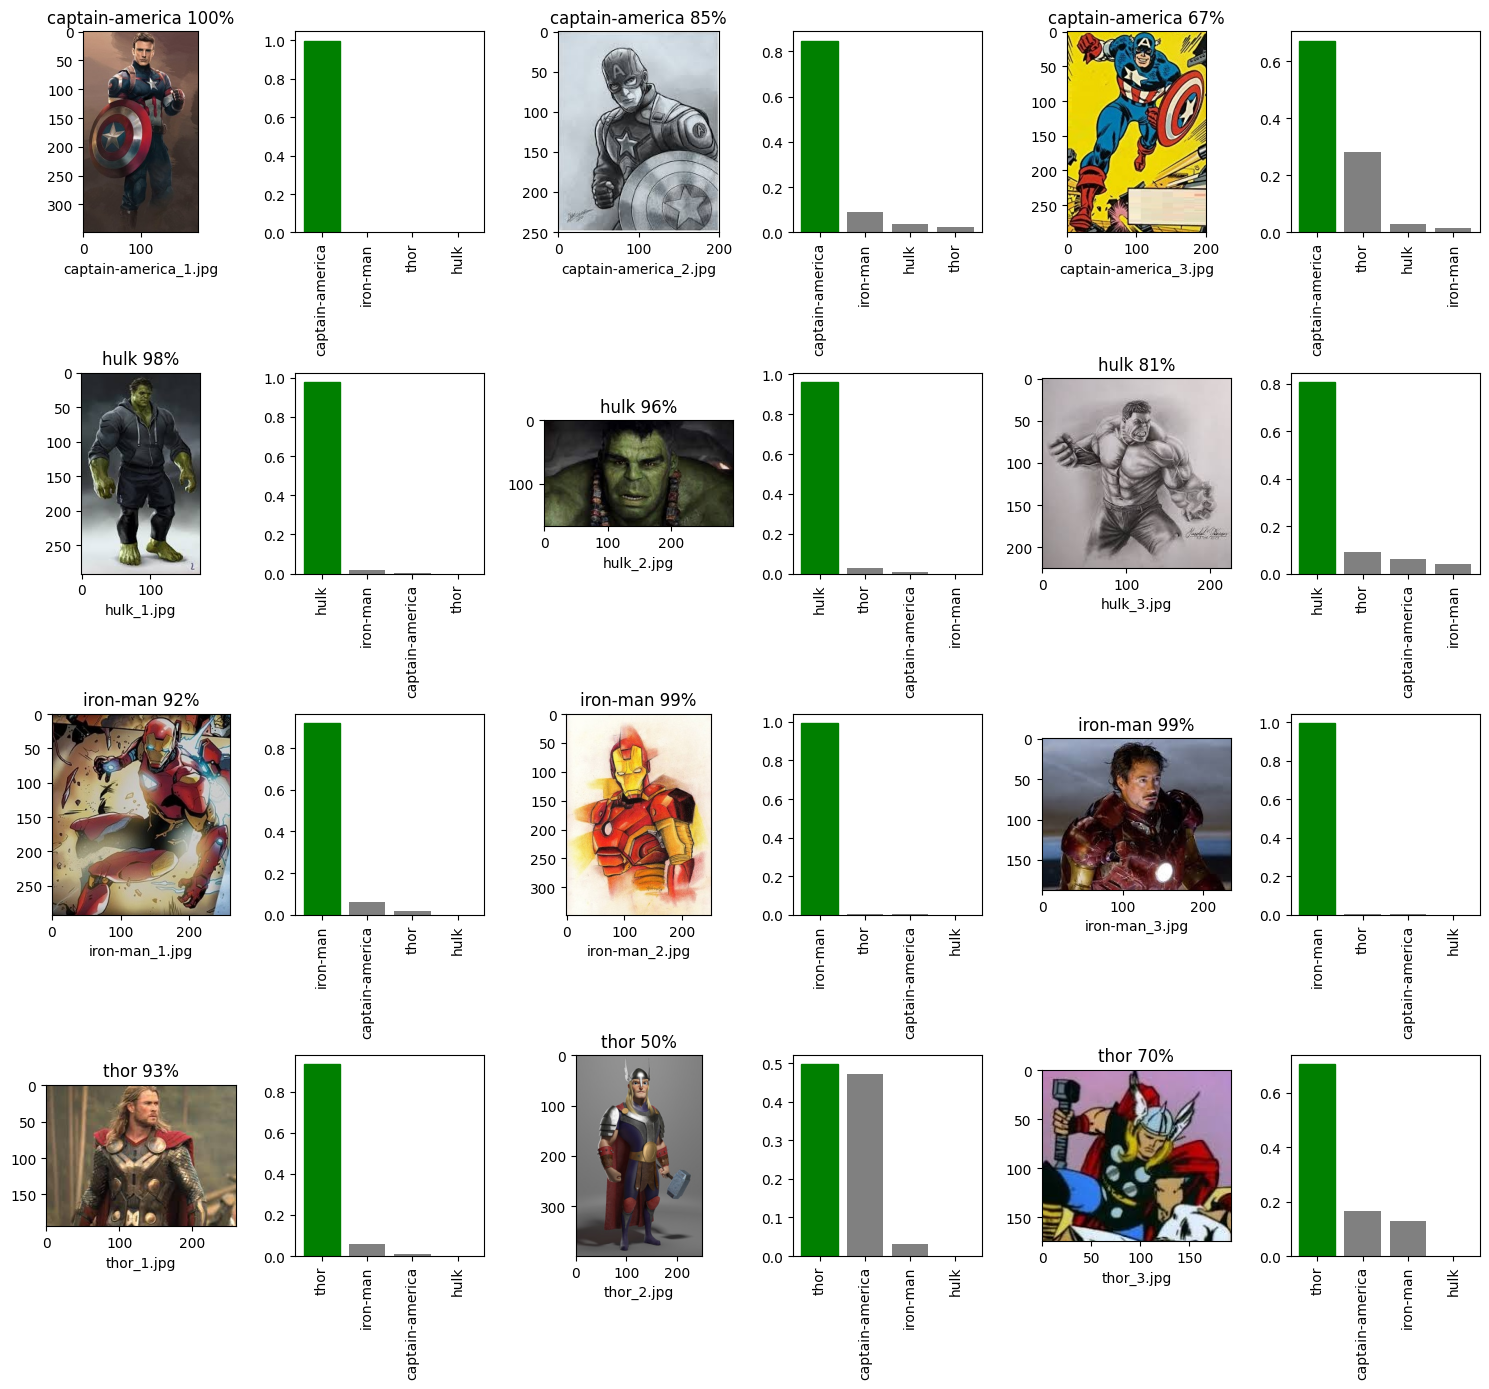

In [21]:
num_rows = 4
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(5 * num_cols, 3.5 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2*i+1)
    plot_pred(images, images_names, pred_probs, labels, i)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(pred_probs, labels, images_names, i)

plt.tight_layout(h_pad=1)
plt.show()

And that's it! Thanks for your attention, I hope you are satisfied with the results, see you next time!

Marek